In [1]:
import numpy as np

# grAdapt
import grAdapt
from grAdapt.space.datatype import Float, Integer
from grAdapt.models import Sequential

# sklearn
# Import datasets, classifiers and performance metrics
from sklearn.metrics import log_loss
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# plot
import matplotlib.pyplot as plt

## 1. Load NIST dataset

In [2]:
# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

## 2. Fit SVM

In [3]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001, probability=True)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [4]:
classifier.score(X_test, y_test)

0.9688542825361512

## 3. Display a test image which has been rightfully classified

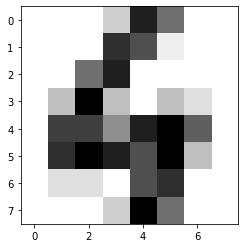

In [5]:
plt.imshow(X_test[500].reshape(8, 8), cmap=plt.cm.binary)

In [6]:
classifier.predict_proba(X_test[500].reshape(1, -1))

array([[0.00491978, 0.00537241, 0.00464466, 0.00444073, 0.90303806,
        0.01827738, 0.04011029, 0.0049646 , 0.00869445, 0.00553763]])

## 4. Goal

We aim to perturbate the image above such that is will be missclassified. A One Pixel Attack is an adversarial example itself with the only difference that only one pixel of the image is perturbated. This reduces the number of dimensions to deal in the optimization problem. We optimize two values: One for the amount of perturbation and one for which pixel we attack. Both values are contrained to be integers. If the domain constraint is not satisfied by the perturbation, 1 is returned. 0 is returned if the perturbated image has been misclassified.

Differently than adversarial attacks, the norm of the perturbation does not has to be minimized. One pixel is already a small perturbation.

### 4.1 Define Black-Box

In [7]:
def one_pixel_attack(per):
    # perturbation has shape (2)
    # X_test[500] has shape (64,)
    pixel_position = int(per[0])
    amount = int(per[1])
    
    
    perturbation = np.zeros((64,))
    perturbation[pixel_position] = amount
    perturbated_image = (X_test[500] + perturbation).reshape(1, -1)
    
    # image not valid because domain contraint not satisfied
    #print(perturbated_image[0][pixel_position].shape)
    #print(perturbated_image.shape)
    if perturbated_image[0][pixel_position] > 16:
        return 1
    
    # let's target the label 5
    # this is also the second highest probabilty of the image
    target_label = np.zeros((10,))
    target_label[6] = 1
    
    pred_label_perturbated = classifier.predict_proba(perturbated_image)
    
    # return cross entropy
    #print(target_label.shape)
    #print(pred_label_perturbated.shape)
    loss = log_loss(target_label, pred_label_perturbated.reshape(10,))
    #print(loss)
    return loss

### 4.2 grAdapt

Using NoGradient accelerates the training process when dealing with high dimensional optimization problems (64 dimension). Only escape functions are used to obtain the next point. The best point is used as the mean and surrounding points are then evaluated.

In [8]:
pos_bound = Integer(0, 63)
amount_bound = Integer(0, 16)

bounds = [pos_bound, amount_bound]

In [9]:
#sur = grAdapt.surrogate.NoGradient()
model = Sequential(random_state=1)#, surrogate=sur)
res = model.minimize(one_pixel_attack, bounds, 1000)

 23%|███████████████████▊                                                                   | 228/1000 [00:00<?, ?it/s]

Sampling 228 random points.
Random function evaluations. This might take a while.
Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.70it/s]


#### 4.2.1 Plot Loss

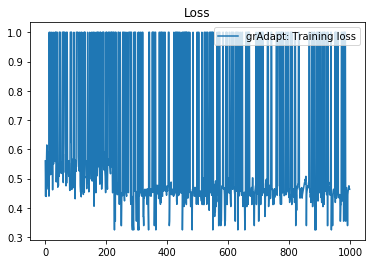

In [10]:
plt.title('Loss')
plt.plot(res['y'], label='grAdapt: Training loss')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()

In [11]:
res['y_sol']

0.324809148872867

#### 4.2.2 Plot x values

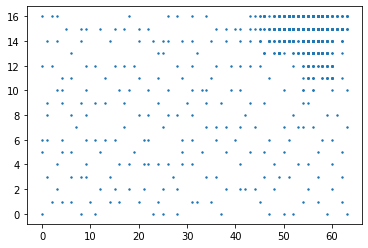

In [12]:
plt.scatter(res['x'][:,0], res['x'][:,1], s=2)

#### 4.2.3 Plot original and perturbated image

In [13]:
pixel_position, amount = res['x_sol']
pixel_position = int(pixel_position)
amount = int(amount)

perturbation = np.zeros((64,))
perturbation[pixel_position] = amount
perturbated_image = (X_test[500] + perturbation).reshape(1, -1)

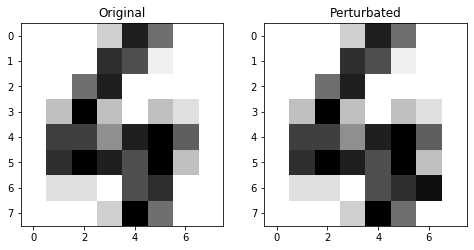

In [14]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
img = [X_test[500], perturbated_image]
labels = ['Original', 'Perturbated', ]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i, title=labels[i-1])
    plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
plt.show()

In [15]:
classifier.predict_proba(perturbated_image.reshape(1, -1))

array([[0.01029155, 0.01470712, 0.01245868, 0.01115855, 0.72381509,
        0.0372631 , 0.13950594, 0.01218204, 0.0231806 , 0.01543732]])

In [16]:
target_label = np.zeros((10,))
target_label[6] = 1

In [17]:
classifier.predict_proba(perturbated_image).reshape(10,)

array([0.01029155, 0.01470712, 0.01245868, 0.01115855, 0.72381509,
       0.0372631 , 0.13950594, 0.01218204, 0.0231806 , 0.01543732])

In [18]:
log_loss(target_label, classifier.predict_proba(perturbated_image).reshape(10,))

0.3394495382638425

### 4.3 BFGS with scipy

In [19]:
import scipy

In [20]:
x0 = grAdapt.utils.sampling.sample_points_bounds(bounds, 1, random_state=1)
res_scipy = scipy.optimize.minimize(one_pixel_attack, x0, bounds=bounds)

In [21]:
res_scipy

      fun: 1
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([26.2723863, 11.5251919])

#### 4.3.1 Plot original and perturbated image

In [22]:
pixel_position, amount = np.round(res_scipy.x)
pixel_position = int(pixel_position)
amount = int(amount)

perturbation = np.zeros((64,))
perturbation[pixel_position] = amount
perturbated_image_scipy = (X_test[500] + perturbation).reshape(1, -1)

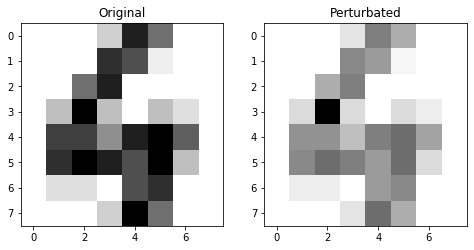

In [23]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
img = [X_test[500], perturbated_image_scipy]
labels = ['Original', 'Perturbated', ]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i, title=labels[i-1])
    plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
plt.show()

In [24]:
classifier.predict(perturbated_image_scipy.reshape(1, -1))

array([4])

## 5. Conclusion

Both grAdapt and BFGS struggle to perturbate the image by one pixel to yield for misclassification.